# 0. 项目初始化
在https://data.mendeley.com/datasets/hhny5ff7yj/1 下载`ebdata_v3.h5ad`,上传到kaggle的input中,然后进行接下来的操作

In [1]:
# 克隆仓库
! git init
! git clone https://github.com/atong01/conditional-flow-matching

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'conditional-flow-matching'...
remote: Enumerating objects: 2195, done.
remote: Counting objects: 100% (600/600), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 2195 (delta 459), reused 378 (delta 378), pack-reused 1595 (from 2)
Receiving objects: 100% (2195/2195), 142.73 MiB | 40.21 MiB/s, done.
Resolving deltas: 100% (1268/1268), done.


In [2]:
cd conditional-flow-matching

/kaggle/working/conditional-flow-matching


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

# 单细胞时间序列插值

本笔记本在类胚体（embryoid body）数据上运行OT-CFM、SB-CFM和SF2M三种模型，数据预处理过程参考`preprocessing`（预处理）文件夹中的笔记本。本文中，我们优化了一个单一网络，用于在二维PHATE投影上对不同时间点的细胞进行建模。该流程同样适用于其他任何数据表征方式。在研究论文中，我们基于主成分分析（PCA）组件和高可变基因（highly variable genes）对模型进行了定量比较。

请注意，运行本笔记本需要`ebdata_v3.h5ad`数据对象，该数据可通过 https://data.mendeley.com/datasets/hhny5ff7yj/1 获取，该数据库中还包含本研究使用的其他单细胞数据集。

另请注意，若要复现论文中的结果，需使用来自以下数据对象的PC维度：https://github.com/KrishnaswamyLab/TrajectoryNet/blob/master/data/eb_velocity_v5.npz 。由于预处理流程不同，该数据对象中的PC维度与本文所用数据的PC维度存在差异。高可变基因的筛选则使用`sc.pp.highly_variable_genes`函数（注：`sc`通常指单细胞分析工具包`scanpy`），参数设置为`n_top_genes=XXX`（XXX代表筛选的高可变基因数量，需根据具体实验设定）。

在本文的模型训练中，我们将所有时间点对整合为一个批次（batch）。在硬件支持大批次数据处理的情况下，这种方式被证明是最稳定的训练策略。


### 关键术语补充说明
- **OT-CFM/SB-CFM/SF2M**：均为用于单细胞时间序列分析的计算模型，其中CFM全称为"Conditional Flow Matching"（条件流匹配），OT（Optimal Transport，最优传输）、SB（Score-Based，分数基）为模型设计的核心思路差异，SF2M具体含义需结合原文上下文，推测为一种基于流（Flow）或分数（Score）的改进模型。
- **PHATE投影**：一种用于高维单细胞数据降维可视化的方法，全称为"Potential of Heat-diffusion for Affinity-based Trajectory Embedding"，可有效保留数据的全局结构和轨迹信息。
- **h5ad文件**：单细胞数据分析中常用的数据存储格式，由`anndata`库定义，可同时存储细胞表达矩阵、元数据（如时间点、细胞类型）等信息。

In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

import warnings

# 忽略所有警告
warnings.filterwarnings("ignore")

savedir = "models/single-cell"
os.makedirs(savedir, exist_ok=True)

d:\develop\anaconda\envs\cfm\lib\site-packages\lightning_fabric\__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [5]:
adata = sc.read_h5ad("/kaggle/input/ebdata/ebdata_v3.h5ad")
adata

AnnData object with n_obs × n_vars = 18203 × 17789
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate', '1d-phate-normalized'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id'
    uns: 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_labels_colors', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_normalized', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

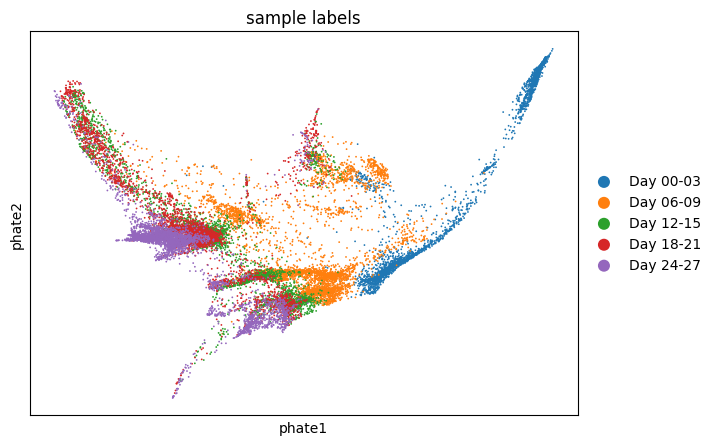

In [6]:
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [7]:
n_times = len(adata.obs["sample_labels"].unique())
# Standardize coordinates
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_phate_standardized"] = coords
X = [
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == t]
    for t in range(n_times)
]

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

In [9]:
import scprep


def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    scprep.plot.scatter(
        adata.obsm["X_phate_standardized"][:, 0],
        adata.obsm["X_phate_standardized"][:, 1],
        c=adata.obs["sample_labels"],
        ax=ax,
    )
    # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    # plt.xticks([])
    # plt.yticks([])
    # plt.axis("off")


def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with points from each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

## 1. OT-CFM
最优传输流匹配

In [10]:
for i in tqdm(range(10000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()

100%|██████████| 10000/10000 [08:15<00:00, 20.19it/s]


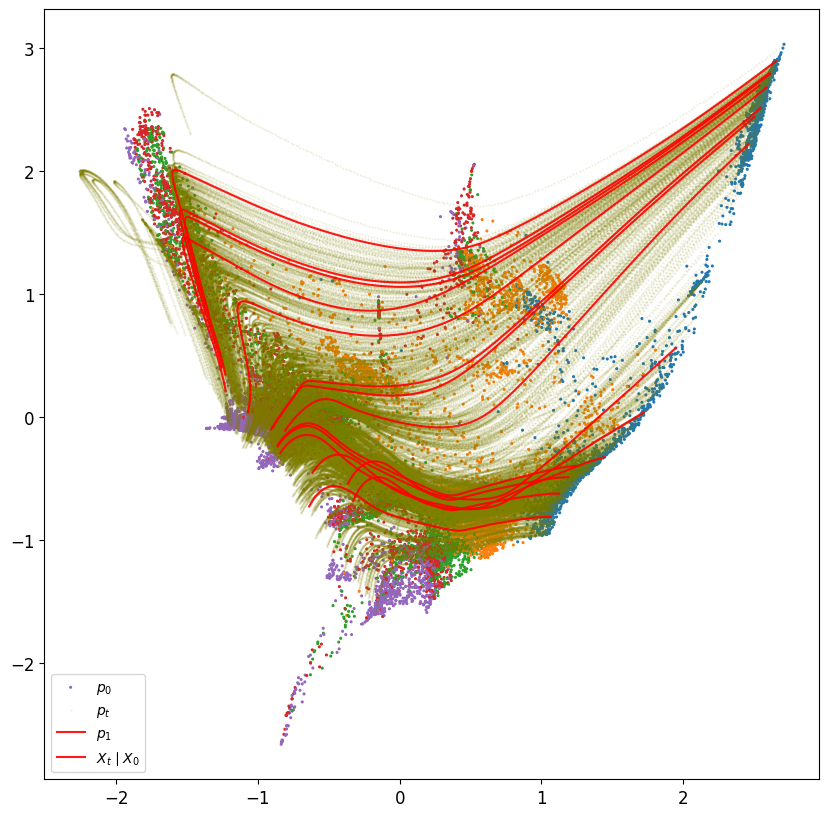

In [11]:
node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [12]:
torch.save(
    {
        "model": ot_cfm_model,
        "optimizer": ot_cfm_optimizer,
    },
    f"{savedir}/ot_cfm_single_cell.pt",
)

## 2. SF2M
薛定谔桥条件流匹配

In [13]:
sigma = 0.25
sf2m_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_score_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_optimizer = torch.optim.AdamW(
    list(sf2m_model.parameters()) + list(sf2m_score_model.parameters()), 1e-4
)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)

In [14]:
max_norm_ut = torch.tensor(0.0)
for i in tqdm(range(10000)):
    sf2m_optimizer.zero_grad()
    t, xt, ut, eps = get_batch(SF2M, X, batch_size, n_times, return_noise=True)
    lambda_t = SF2M.compute_lambda(t % 1)
    vt = sf2m_model(torch.cat([xt, t[:, None]], dim=-1))
    st = sf2m_score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    # max_norm_ut = torch.maximum(torch.max(torch.sum(ut**2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    if i % 1000 == 0:
        # print(max_norm_ut)
        
        print(f"iteration:{i}: flow_loss:{flow_loss.item():0.2f}, score_loss:{score_loss.item():0.2f}")
    loss = flow_loss + score_loss

    loss.backward()
    sf2m_optimizer.step()

  0%|          | 4/10000 [00:00<10:05, 16.51it/s]

iteration:0: flow_loss:1.11, score_loss:2.12


 10%|█         | 1003/10000 [00:51<07:41, 19.51it/s]

iteration:1000: flow_loss:0.32, score_loss:0.90


 20%|██        | 2003/10000 [01:43<06:52, 19.37it/s]

iteration:2000: flow_loss:0.33, score_loss:0.82


 30%|███       | 3003/10000 [02:35<05:57, 19.58it/s]

iteration:3000: flow_loss:0.27, score_loss:0.85


 40%|████      | 4003/10000 [03:26<05:08, 19.44it/s]

iteration:4000: flow_loss:0.25, score_loss:0.86


 50%|█████     | 5003/10000 [04:17<04:16, 19.49it/s]

iteration:5000: flow_loss:0.29, score_loss:0.83


 60%|██████    | 6004/10000 [05:09<03:23, 19.59it/s]

iteration:6000: flow_loss:0.36, score_loss:0.83


 70%|███████   | 7003/10000 [06:00<02:39, 18.78it/s]

iteration:7000: flow_loss:0.25, score_loss:0.85


 80%|████████  | 8004/10000 [06:52<01:41, 19.72it/s]

iteration:8000: flow_loss:1.36, score_loss:0.81


 90%|█████████ | 9004/10000 [07:43<00:50, 19.57it/s]

iteration:9000: flow_loss:0.34, score_loss:0.82


100%|██████████| 10000/10000 [08:34<00:00, 19.43it/s]


In [15]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0.to(device),
        t_span=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

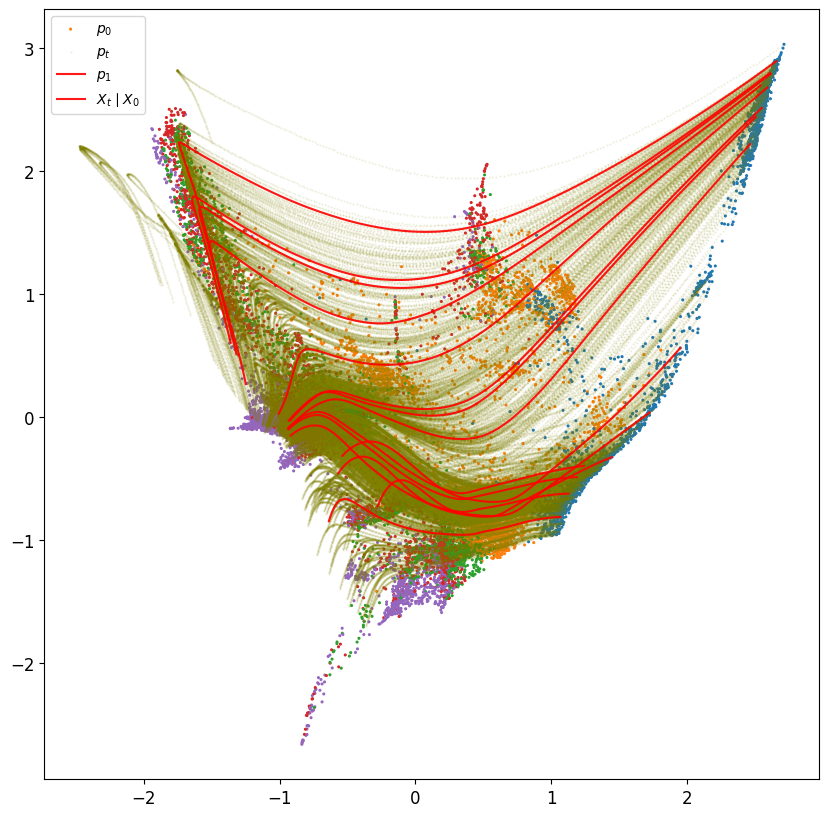

In [16]:
plot_trajectories(traj.cpu().numpy())

In [17]:
class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        y = y.view(-1, *self.input_size)
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x).flatten(start_dim=1) + self.score(x).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma


sde = SDE(sf2m_model, sf2m_score_model, input_size=(2,), sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0.to(device),
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

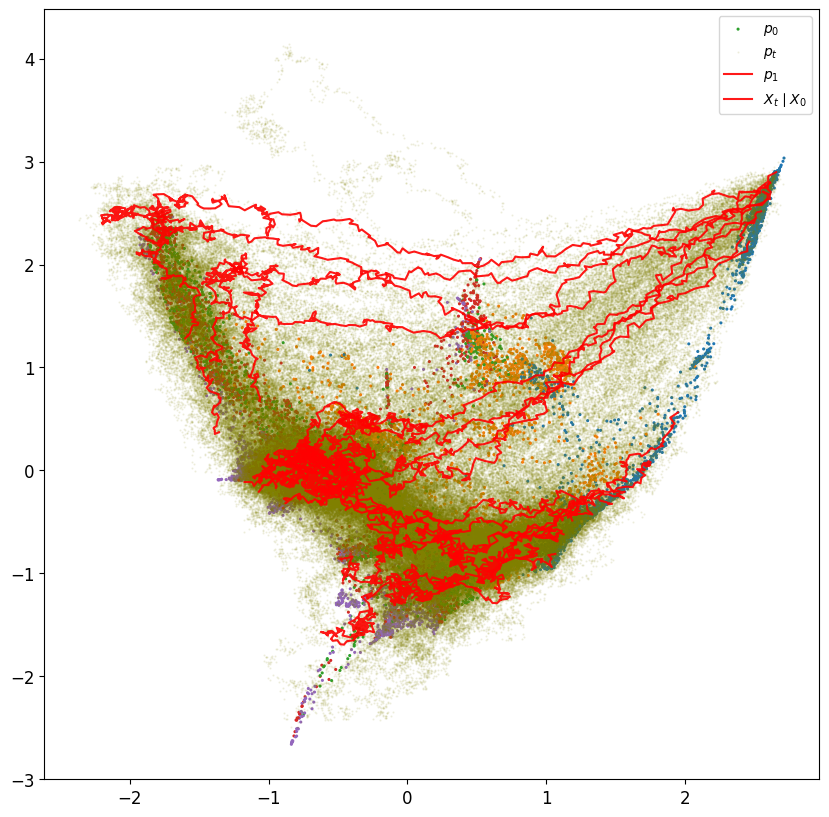

In [18]:
plot_trajectories(sde_traj.detach().cpu().numpy())

In [19]:
torch.save(
    {
        "model": sf2m_model,
        "score_model": sf2m_score_model,
        "optimizer": sf2m_optimizer,
    },
    f"{savedir}/sf2m_single_cell_sigma_{sigma}.pt",
)

## 3. 从高斯分布出发的CFM
3-5小节为本人增加的实验。
用TargetConditionalFlowMatcher采样

In [20]:
sigma = 0.1
dim = 2
gaussian_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
gaussian_cfm_optimizer = torch.optim.Adam(gaussian_cfm_model.parameters(), 1e-4)
FM = TargetConditionalFlowMatcher(sigma=sigma)

for i in tqdm(range(10000)):
    gaussian_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = gaussian_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    gaussian_cfm_optimizer.step()

100%|██████████| 10000/10000 [00:34<00:00, 292.81it/s]


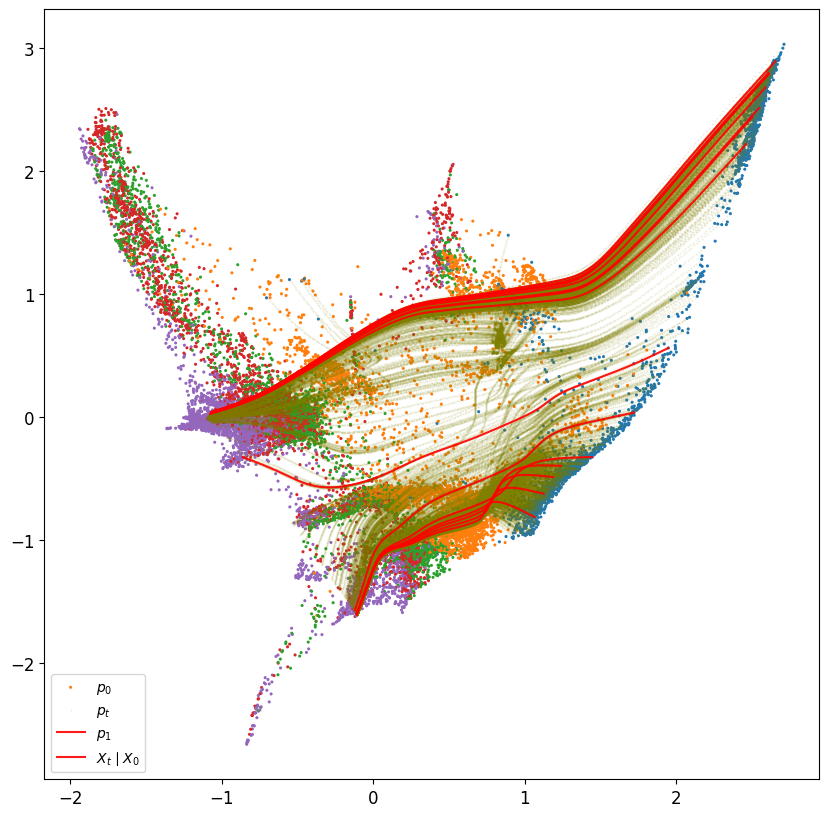

In [21]:
node = NeuralODE(torch_wrapper(gaussian_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [22]:
torch.save(
    {
        "model": gaussian_cfm_model,
        "optimizer": gaussian_cfm_optimizer,
    },
    f"{savedir}/gaussian_cfm_single_cell.pt",
)

## 4. I-CFM
用ConditionalFlowMatcher采样

In [23]:
sigma = 0.1
dim = 2
i_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
i_cfm_optimizer = torch.optim.Adam(i_cfm_model.parameters(), 1e-4)
FM = ConditionalFlowMatcher(sigma=sigma)

for i in tqdm(range(10000)):
    i_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = i_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    i_cfm_optimizer.step()

100%|██████████| 10000/10000 [00:31<00:00, 322.52it/s]


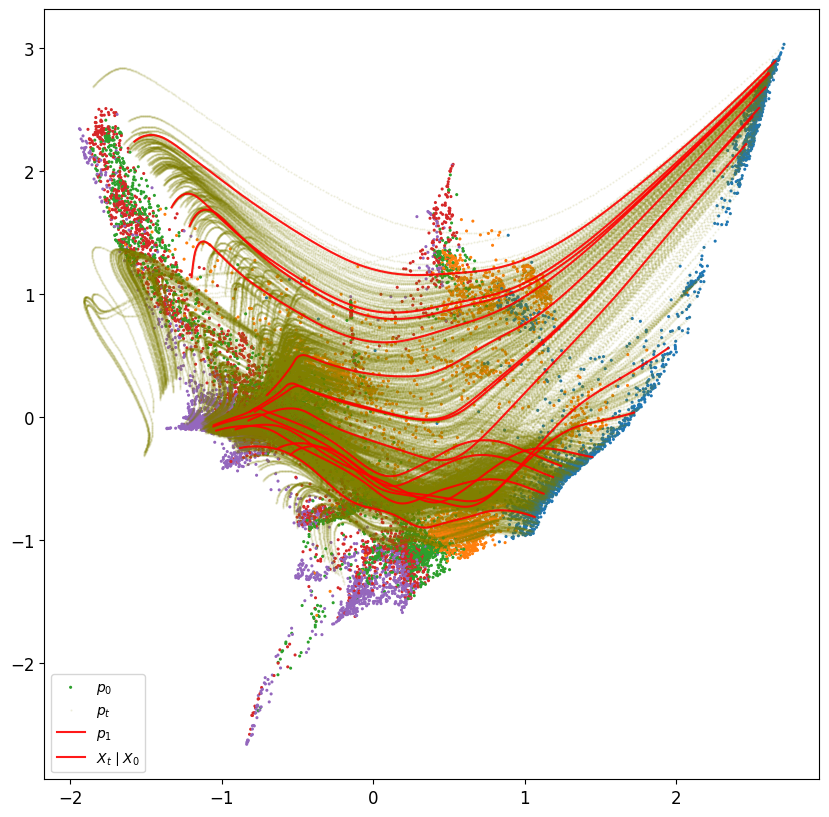

In [24]:
node = NeuralODE(torch_wrapper(i_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [25]:
torch.save(
    {
        "model": i_cfm_model,
        "optimizer": i_cfm_optimizer,
    },
    f"{savedir}/i_cfm_single_cell.pt",
)

## 5. 方差保留的CFM
用VariancePreservingConditionalFlowMatcher采样

In [26]:
sigma = 0.1
dim = 2
vp_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
vp_cfm_optimizer = torch.optim.Adam(vp_cfm_model.parameters(), 1e-4)
FM = VariancePreservingConditionalFlowMatcher(sigma=sigma)

for i in tqdm(range(10000)):
    vp_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = vp_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    vp_cfm_optimizer.step()

100%|██████████| 10000/10000 [00:35<00:00, 280.49it/s]


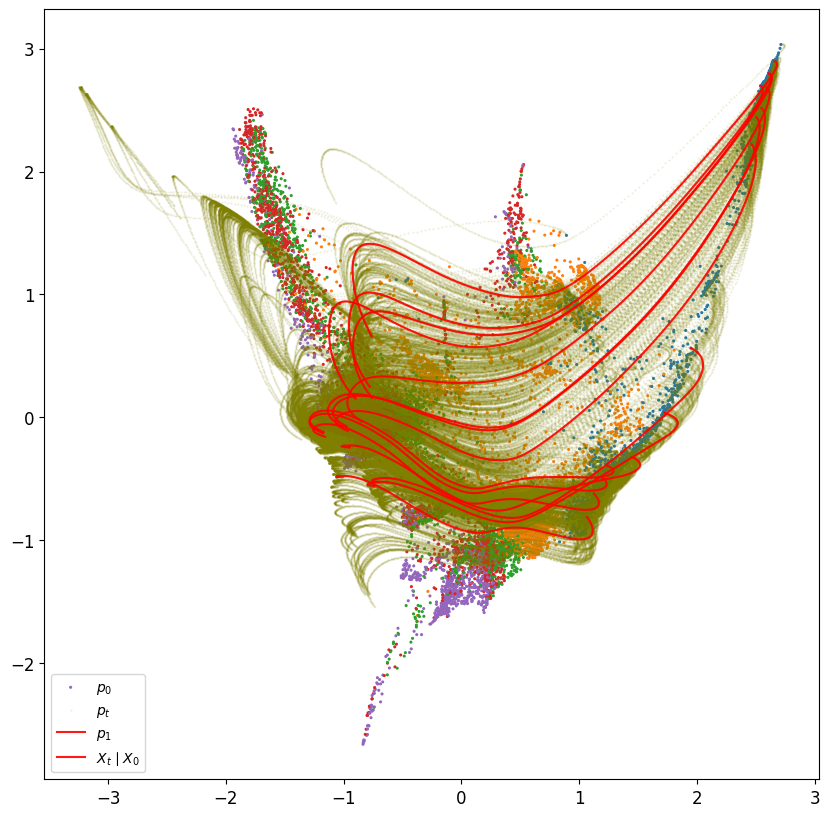

In [27]:
node = NeuralODE(torch_wrapper(vp_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [28]:
torch.save(
    {
        "model": vp_cfm_model,
        "optimizer": vp_cfm_optimizer,
    },
    f"{savedir}/vp_cfm_single_cell.pt",
)

# Evolution of trajectories between SF2M's probability flow ODE (SB-CFM) and SF2M

SB-CFM 与 SF2M 的轨迹演化
SB-CFM的轨迹是决定性的, 而SF2M是通过随机微分方程求解的

## Starting from a cell at day 0

In [29]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0[2].repeat(20).view(20, 2).to(device),
        t_span=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()
# plot_trajectories(traj.cpu().numpy())

In [30]:
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0[2].repeat(20).view(20, 2).to(device),
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

In [31]:
traj = traj.detach().cpu().numpy()
sde_traj = sde_traj.detach().cpu().numpy()

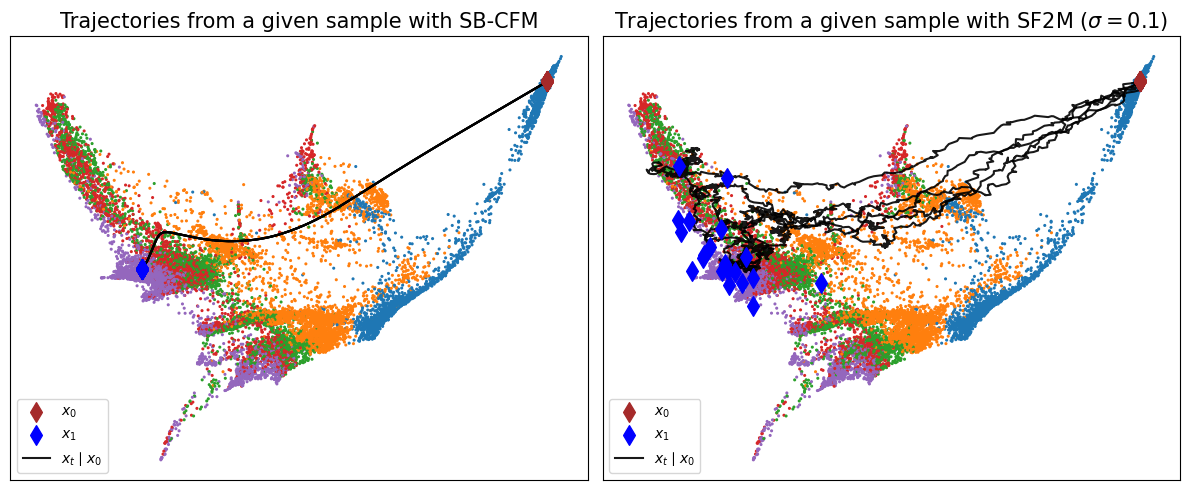

In [32]:
n = 2000
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(traj[0, :n, 0], traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3)
ax1.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3)

for i in range(5):
    ax1.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax1,
    legend=None,
)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Trajectories from a given sample with SB-CFM", fontsize=15)
ax1.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])


ax2.scatter(
    sde_traj[0, :n, 0], sde_traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3
)
ax2.scatter(
    sde_traj[-1, :n, 0], sde_traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3
)

for i in range(5):
    ax2.plot(sde_traj[:, i, 0], sde_traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax2,
    legend=None,
)

ax2.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title(
    r"Trajectories from a given sample with SF2M $(\sigma={})$".format(sigma), fontsize=15
)

plt.tight_layout()
plt.savefig("conditonal_trajectory_sf2m_sigma_{}.png".format(sigma))

## Starting from a cell at an older time (day 25)

In [33]:
len(X)

5

In [34]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[1][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0[1].repeat(15).view(15, 2).to(device),
        t_span=torch.linspace(1, n_times - 1, 300, device=device),
    ).cpu()

with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0[1].repeat(15).view(15, 2).to(device),
        ts=torch.linspace(1, n_times - 1, 300, device=device),
    ).cpu()

traj = traj.detach().cpu().numpy()

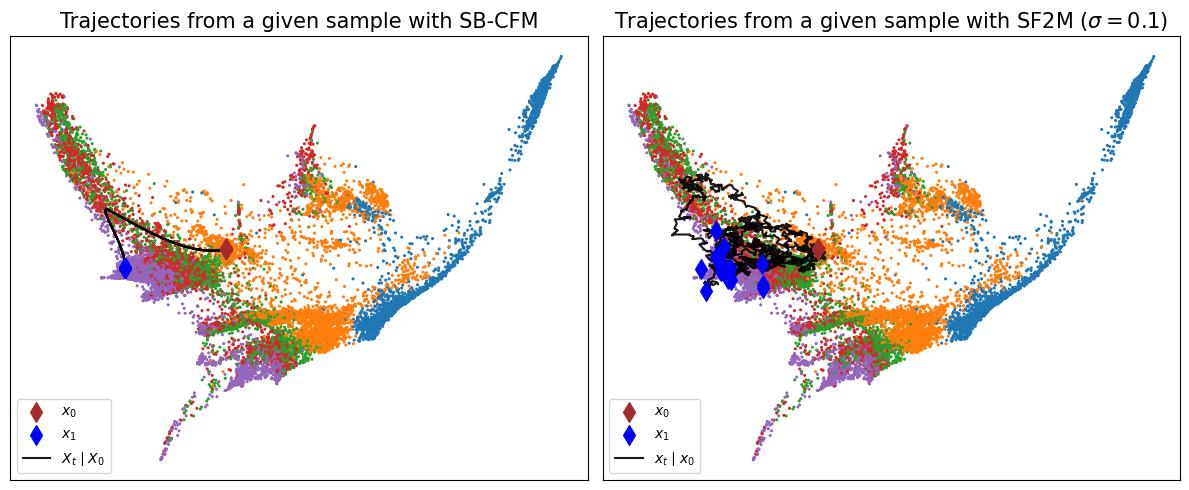

In [35]:
n = 2000
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.scatter(traj[0, :n, 0], traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3)
ax1.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3)

for i in range(5):
    ax1.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax1,
    legend=None,
)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Trajectories from a given sample with SB-CFM", fontsize=15)
ax1.legend([r"$x_0$", r"$x_1$", r"$X_t \mid X_0$"])


ax2.scatter(
    sde_traj[0, :n, 0], sde_traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3
)
ax2.scatter(
    sde_traj[-1, :n, 0], sde_traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3
)

for i in range(5):
    ax2.plot(sde_traj[:, i, 0], sde_traj[:, i, 1], alpha=0.9, c="black", zorder=2)


scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax2,
    legend=None,
)

ax2.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title(
    r"Trajectories from a given sample with SF2M $(\sigma={})$".format(sigma), fontsize=15
)
# plt.axis("off")

plt.tight_layout()
plt.savefig("conditonal_trajectory_sf2m_sigma_{}_from_later_time.png".format(sigma))

### As SB-CFM is a deterministic process, it only ends up at one final location contrary to our model SF2M that models a stochastic process and produces different outputs.
由于 SB-CFM 是一个确定性过程，它最终只会到达一个固定的终点；而我们的模型 SF2M 则不同，它对随机过程进行建模，因此能产生多种不同的输出结果

In [1]:
import torch
import torchvision

# 1. 查看torch版本（核心）
print(f"PyTorch 版本: {torch.__version__}")

# 2. 查看torchvision版本
print(f"TorchVision 版本: {torchvision.__version__}")

# 3. 额外验证（可选，确认CUDA/环境）
print(f"CUDA 版本（torch内置）: {torch.version.cuda}")
print(f"当前设备GPU数量: {torch.cuda.device_count()}")
print(f"当前使用GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch 版本: 2.8.0+cpu
TorchVision 版本: 0.23.0+cpu
CUDA 版本（torch内置）: None
当前设备GPU数量: 0
当前使用GPU: CPU
